#Market Risk and VaR Estimation Methodologies with Python

### About this notebook
Documention prepared by **Jesus Perez Colino**.
Version 0.1, Released 25/11/2013, Alpha

- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.
- **Summary**: This notebook is a quick summary of how to implement the different estimation methods for the VaR in Python.
- **Reproducibility conditions**: the content in this technical note can be reproduce in your computer under the following versions of the Python's packages: 

In [225]:
%matplotlib inline

import numpy as np
import scipy as sci
import scipy.stats as scs
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from pandas.io.data import DataReader, DataFrame

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
#pd.set_option('display.width', 500)
#pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

from sys import version
print ' Reproducibility conditions for the VaR estimation'.center(80, '-')
print 'Python version:     ' + version
print 'Numpy version:      ' + np.__version__
print 'Scipy version:      ' + sci.__version__
print 'Pandas version:     ' + pd.__version__
print 'Matplotlib ver:     ' + mpl.__version__
print 'IPython version:    ' + IPython.__version__

print '-'*80

--------------- Reproducibility conditions for the VaR estimation---------------
Python version:     2.7.5 |Anaconda 2.3.0 (64-bit)| (default, Jul  1 2013, 12:37:52) [MSC v.1500 64 bit (AMD64)]
Numpy version:      1.9.2
Scipy version:      0.15.1
Pandas version:     0.16.2
Matplotlib ver:     1.4.3
IPython version:    3.2.0
--------------------------------------------------------------------------------


## Introduction: Stock market returns and volatility

Let's start downloading some stock market data for Google (stock market ticker is `GOOG`) from the year 2010 and plot its evolution over time.

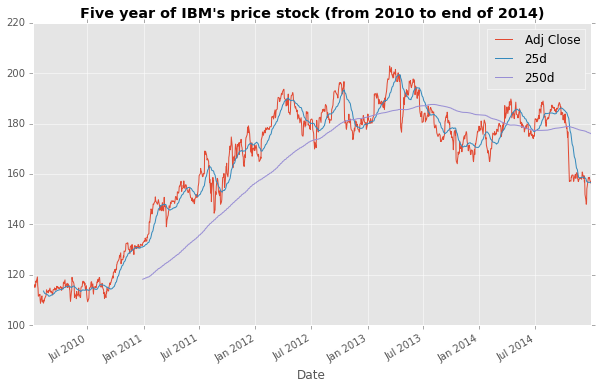

In [202]:

IBM = DataReader(name = "IBM", 
                  data_source = "yahoo", 
                  start = datetime(2010, 1, 1), 
                  end = datetime(2014, 12, 31))

IBM['25d'] = pd.rolling_mean(IBM['Adj Close'], 
                              window=25)

IBM['250d'] = pd.rolling_mean(IBM['Adj Close'], 
                               window=250)

IBM[['Adj Close', '25d', '250d']].plot()
plt.title("Five year of IBM's price stock (from 2010 to end of 2014)", 
          weight='bold');


Usually, in financial modelling, and specifically in risk analysis, we are more interested in the relative daily changes than in the absolute value of the stock, so plot the relative daily returns over the Google price time series. 

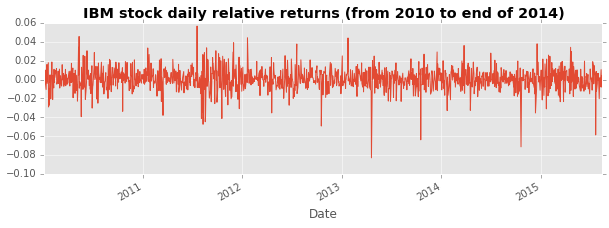

In [171]:
fig = plt.figure()
fig.set_size_inches(10,3)
IBM["Adj Close"].pct_change().plot()
plt.title(u"IBM stock daily relative returns (from 2010 to end of 2014)", 
          weight='bold');

In [172]:
IBM["Adj Close"].pct_change().describe()

count    1413.000000
mean        0.000268
std         0.011737
min        -0.082790
25%        -0.005820
50%         0.000185
75%         0.006519
max         0.056652
Name: Adj Close, dtype: float64

IBM standard devation over daily relative returns:  0.0116829105309


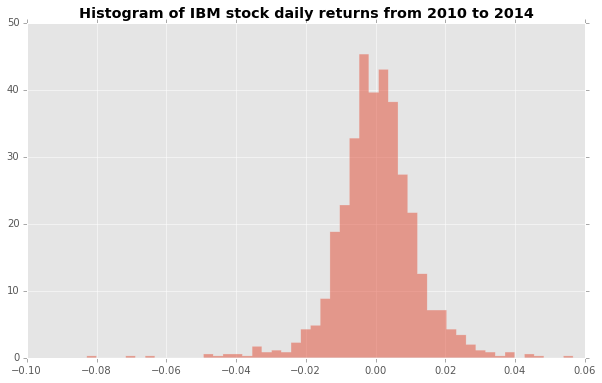

In [198]:
(IBM["Adj Close"]
 .pct_change()
 .hist(bins=50, normed=True, histtype='stepfilled', alpha=0.5))

plt.title(u"Histogram of IBM stock daily returns from 2010 to 2014", 
          weight='bold')

print 'IBM standard devation over daily relative returns: ', IBM["Adj Close"].pct_change().std()

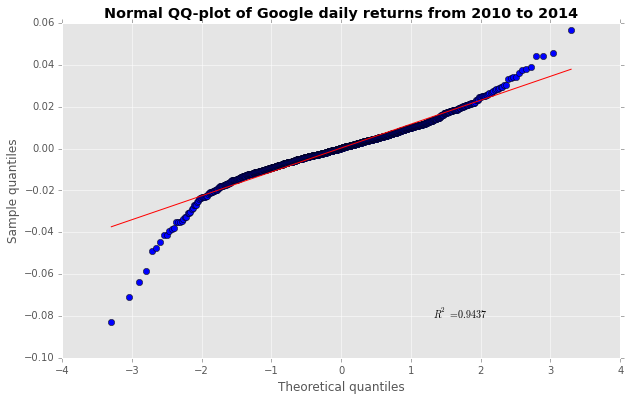

In [175]:
Q = IBM["Adj Close"].pct_change().dropna().as_matrix()
scipy.stats.probplot(Q, 
                     dist = scipy.stats.norm, 
                     plot = plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot of Google daily returns from 2010 to 2014", 
          weight="bold")
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles');

In [177]:
def normality_tests(array):
    ''' Tests for normality distribution of given data set'''
    print "Skew of data set %14.3f" % scs.skew(array)
    print "Skew test p-value %14.3f" % scs.skewtest(array)[1]
    print "Kurt of data set %14.3f" % scs.kurtosis(array)
    print "Kurt test p-value %14.3f" % scs.kurtosistest(array)[1]
    print "Norm test p-value %14.3f" % scs.normaltest(array)[1]
    
returns = np.array(IBM["Adj Close"].pct_change().dropna())
normality_tests(returns.flatten())

Skew of data set         -0.565
Skew test p-value          0.000
Kurt of data set          5.159
Kurt test p-value          0.000
Norm test p-value          0.000


The test values indicate that the log returns are not normally distributed — i.e., they
show p-values below of 0.05 , therefore the normality assumption is rejected

Let's see whether the daily returns are better represented by a Student-t distribution.

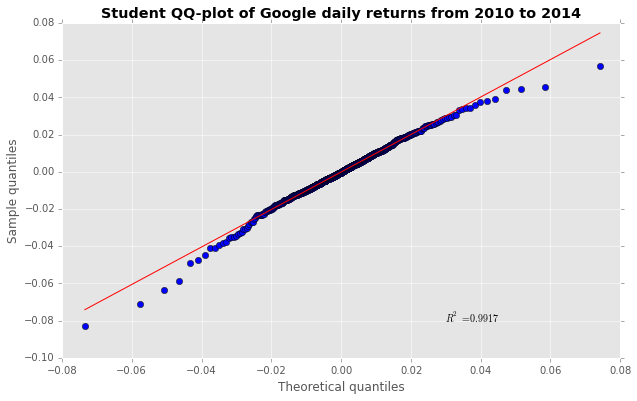

In [178]:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, 
                     dist = scipy.stats.t, 
                     sparams = (tdf, tmean, tsigma), 
                     plot = plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot of Google daily returns from 2010 to 2014", 
          weight="bold")
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles');

Student's t distribution does seem to fit better (look in particular at the tails of the distribution).

## Value at Risk using the Historical Method

Method: we calculate **empirical quantiles** from a histogram of daily returns. Let's do that for the returns of Halliburton (stock market ticker `HAL`) over 2010--2014 (in reality, you would look at a longer time horizon, and give more weighting to recent activity than to activity several years ago).

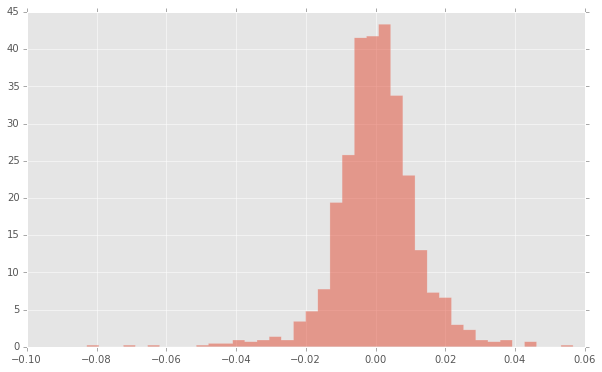

In [179]:
start = datetime(2010, 1, 1)
end   = datetime(2014, 12, 31)
stock = DataReader("IBM", "yahoo", start, end)
returns = stock["Close"].pct_change().dropna()
mean = returns.mean()
sigma = returns.std()
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);

In [180]:
returns.quantile(0.05)

-0.016916969265236625

The `0.05` empirical quantile of daily returns is at `-0.017`. That means that with `95%` confidence, our worst daily loss will not exceed `1.7%`. If we have a 1M USD investment, our one-day 5% VaR is `0.017` * 1M USD = `17,000` USD.

## Value at Risk using the variance-covariance method

Method: calculate analytic quantiles by curve fitting to historical data. Here, we use Student's t distribution (we checked above that it represents daily returns relatively well).

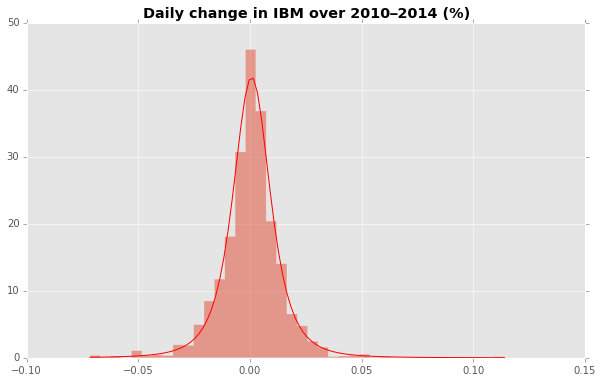

In [213]:
support = np.linspace(returns.min(), returns.max(), 100)
returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title(u"Daily change in IBM over 2010–2014 (%)", weight='bold');

In [214]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.022842775200019434

Our analytic 0.05 quantile is at -0.0228, so with 95% confidence, our worst daily loss will not exceed 2.28%. For a 1M€ investment, one-day Value at Risk is 0.0228 * 1M€ = 22.8k€.

## Value at Risk using the Monte Carlo method

**Method**: run many trials with random market conditions, calculating portfolio loss for each trial. Use the aggregated trial data to establish a profile of the porfolio's risk characteristics. See the slides associated with this notebook for details.

**Hypothesis**: stock market evolution can be simulated by geometric Brownian motion (this is a rough hypothesis; see the literature on stochastic methods in finance for more sophisticated, and more realistic, models, such as jump diffusion).

Start by defining some parameters of the geometric Brownian motion.

In [208]:
days = 300   # time horizon
dt = 1/float(days)

mu = returns.mean()
sigma = returns.std()

startprice = IBM['Adj Close'][-1]

This function simulates one stock market evolution, and returns the price evolution as an array. It simulates geometric Brownian motion using random numbers drawn from a normal distribution (see accompanying slides).

In [209]:
def random_walk(startprice):
    price = np.zeros(days)
    shock = np.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = np.random.normal(loc = mu * dt, 
                                    scale = sigma * np.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

Let's simulate 30 random walks, starting from an initial stock price of 10€, for a duration of 300 days.

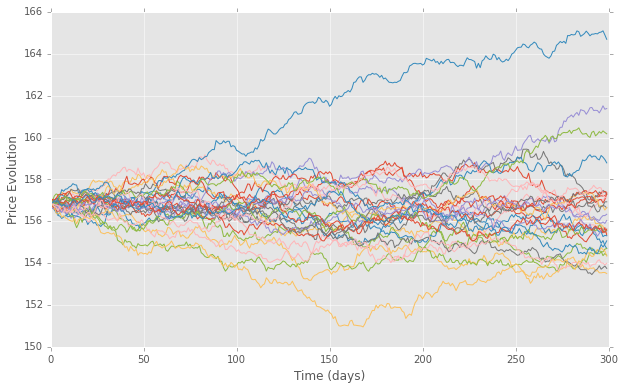

In [210]:
for run in range(30):
    plt.plot(random_walk(startprice))
plt.xlabel("Time (days)")
plt.ylabel("Price Evolution");

Now let's run a big Monte Carlo simulation of random walks of this type, to obtain the probability distribution of the final price, and obtain quantile measures for the Value at Risk estimation. This will take a little time to run (return variable `runs` if you want faster, but less representative, results).

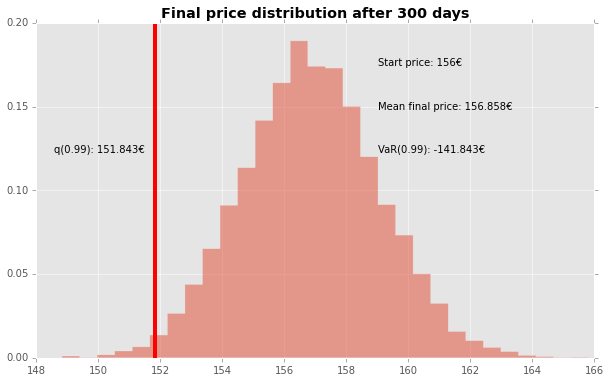

In [211]:
runs = 10000
simulations = np.zeros(runs)
for run in range(runs):
    simulations[run] = random_walk(startprice)[days-1]
q = np.percentile(simulations, 1)
plt.hist(simulations, normed=True, bins=30, histtype='stepfilled', alpha=0.5)
plt.figtext(0.6, 0.8, u"Start price: 156€")
plt.figtext(0.6, 0.7, u"Mean final price: %.3f€" % simulations.mean())
plt.figtext(0.6, 0.6, u"VaR(0.99): %.3f€" % (10 - q,))
plt.figtext(0.15, 0.6, u"q(0.99): %.3f€" % q)
plt.axvline(x=q, linewidth=4, color='r')
plt.title(u"Final price distribution after %s days" % days, weight='bold');

## Correlation between stocks

In [215]:
start = datetime(2005, 1, 1)
end   = datetime(2015, 1, 1)
CAC = DataReader("^FCHI", "yahoo", start, end)
DAX = DataReader("^GDAXI", "yahoo", start, end)
HSI = DataReader("^HSI", "yahoo", start, end)
AORD = DataReader("^DJI", "yahoo", start, end)

df = DataFrame({ 'CAC': CAC["Close"].pct_change(),
                 'DAX': DAX["Close"].pct_change(),
                 'HSI': HSI["Close"].pct_change(),
                 'DJI': AORD["Close"].pct_change() })
dfna = df.dropna()

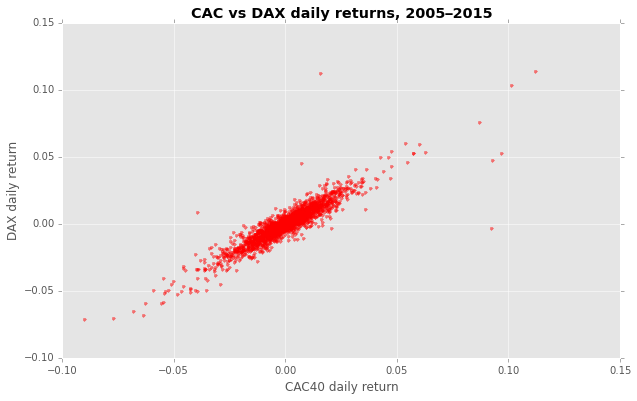

In [216]:
plt.plot(dfna["CAC"], dfna["DAX"], 'r.', alpha=0.5)
plt.xlabel(u"CAC40 daily return")
plt.ylabel(u"DAX daily return")
plt.title(u"CAC vs DAX daily returns, 2005–2015", weight='bold');

In [217]:
scipy.stats.pearsonr(dfna["CAC"], dfna["DAX"])

(0.91978706267326948, 0.0)

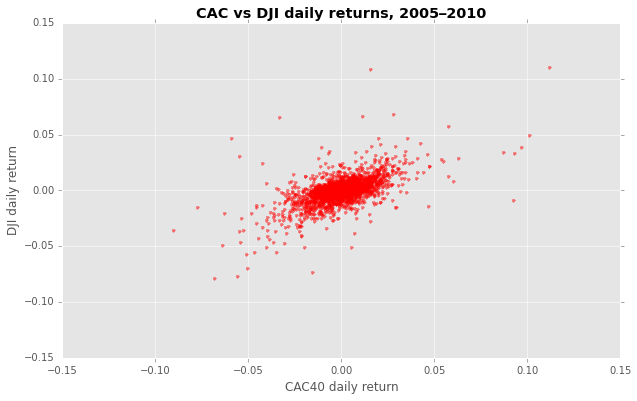

In [219]:
plt.plot(dfna["CAC"], dfna["DJI"], 'r.', alpha=0.5)
plt.xlabel(u"CAC40 daily return")
plt.ylabel(u"DJI daily return")
# ensure square aspect ratio
plt.axes().set_xlim(-0.15, 0.15)
plt.axes().set_ylim(-0.15, 0.15)
plt.title(u"CAC vs DJI daily returns, 2005–2010", weight='bold');

In [220]:
scipy.stats.pearsonr(dfna["CAC"], dfna["DJI"])

(0.61071367628752282, 6.876663069737151e-248)

CAC t fit: mean=0.000394429241528, scale=0.00946577887963, df=3.29037745725


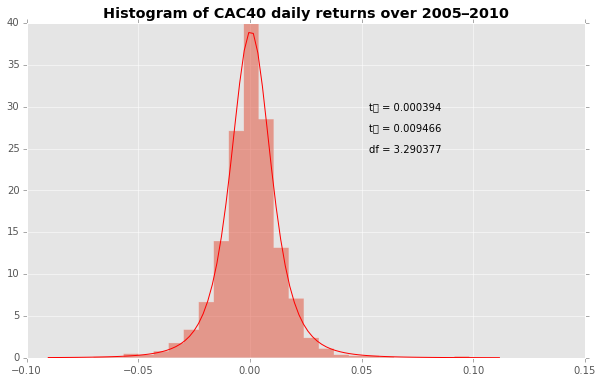

In [221]:
returns = dfna["CAC"]
returns.hist(bins=30, normed=True, histtype='stepfilled', alpha=0.5)
support = np.linspace(returns.min(), returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
print("CAC t fit: mean={}, scale={}, df={}".format(tmean, tsigma, tdf))
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.figtext(0.6, 0.7, u"tμ = {:.3}".format(tmean))
plt.figtext(0.6, 0.65, u"tσ = %3f" % tsigma)
plt.figtext(0.6, 0.6, u"df = %3f" % tdf)
plt.title(u"Histogram of CAC40 daily returns over 2005–2010", weight='bold');

DAX t fit: mean=0.00073986478715, scale=0.00880772772443, df=3.05298676457


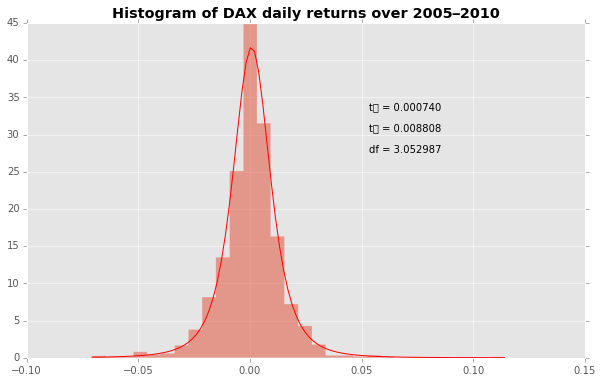

In [222]:
returns = dfna["DAX"]
returns.hist(bins=30, normed=True, histtype='stepfilled', alpha=0.5)
support = np.linspace(returns.min(), returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
print("DAX t fit: mean={}, scale={}, df={}".format(tmean, tsigma, tdf))
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.figtext(0.6, 0.7, u"tμ = %3f" % tmean)
plt.figtext(0.6, 0.65, u"tσ = %3f" % tsigma)
plt.figtext(0.6, 0.6, u"df = %3f" % tdf)
plt.title(u"Histogram of DAX daily returns over 2005–2010", weight='bold');

Let's simulate random joint stock returns from a joint distribution of fitted-CAC and fitted-DAX according to the distribution parameters estimated above, and plot the results. We need these simulated joint returns to do a Monte Carlo VaR analysis of a stock portfolio composed of CAC and DAX stock.

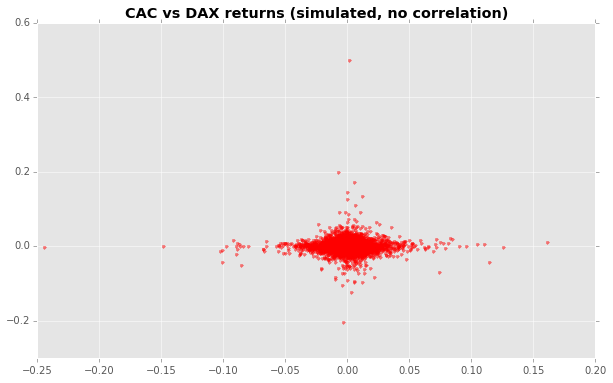

In [223]:
runs = 5000
fittedCAC = np.zeros(runs, float)
fittedDAX = np.zeros(runs, float)
for i in range(runs):
    fittedCAC[i] = scipy.stats.t.rvs(loc=0.000478137351981, 
                                     scale=0.00898201242824, 
                                     df=2.75557323986)
    fittedDAX[i] = scipy.stats.t.rvs(loc=0.000847802944791, 
                                     scale=0.00878082895409, 
                                     df=2.71766905436)
plt.plot(fittedCAC, fittedDAX, 'r.', alpha=0.5)
plt.title(u"CAC vs DAX returns (simulated, no correlation)", weight='bold');

**Problem**: our sampling from these fitted random variables doesn't match the observations from the real markets (scroll up to check the real CAC/DAX scatterplot). 

We need some way of generating a sample that respects the *correlation* between the input variables. All is revealed in the next episode on *Copula and multivariate dependencies*.